# Raissa Anggia Maharani

# 2206048581

Model Analisis Sentimen di Hugging Face

Pada kali ini, saya menggunakan model *financial news sentiment analysis* yang bisa diakses pada link berikut ini: https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis

In [1]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

Try to predict a sentence "The company's earnings exceeded expectations."

In [4]:
# Load the model and tokenizer
model_name = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
# Load tokenizer and model explicitly
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a pipeline for text classification
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Define a sentence for prediction
sentence = "The company's earnings exceeded expectations."

# Make a prediction
prediction = pipe(sentence)

# Print the prediction
print(prediction)


[{'label': 'positive', 'score': 0.999265730381012}]


Check the model’s accuracy using a synthetic dataset

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score
from transformers import pipeline

# Load the sentiment analysis pipeline
pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# Create a synthetic dataset (text samples with their expected labels)
# For example: ['positive', 'negative', 'neutral']
synthetic_data = [
    ("The company announced a record profit this quarter.", "positive"),
    ("Customer feedback has been overwhelmingly positive.", "positive"),
    ("The recent market trends show promising growth.", "positive"),
    ("Stock prices are expected to rise in the coming months.", "positive"),
    ("Investors are concerned about the upcoming economic downturn.", "negative"),
    ("Sales dropped significantly due to the recent scandal.", "negative"),
    ("The market is experiencing volatility.", "neutral"),
    ("Analysts predict a stable recovery for the industry.", "neutral"),
    ("The CEO's speech was reassuring but lacked specifics.", "neutral"),
    ("While there are challenges, the overall outlook remains bright.", "positive"),
]
# Separate the texts and the actual labels
texts, actual_labels = zip(*synthetic_data)

# Make predictions
predictions = pipe(list(texts))

# Extract the predicted labels from the pipeline output
predicted_labels = [prediction['label'].lower() for prediction in predictions]

# Map the labels to their corresponding sentiment (positive, negative, neutral)
mapped_labels = []
for label in predicted_labels:
    if label == 'positive':
        mapped_labels.append('positive')
    elif label == 'negative':
        mapped_labels.append('negative')
    else:
        mapped_labels.append('neutral')

# Calculate accuracy
accuracy = accuracy_score(actual_labels, mapped_labels)

# Print the accuracy
print(f"Model Accuracy: {accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Model Accuracy: 0.80


Implement attention transformer on that model

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


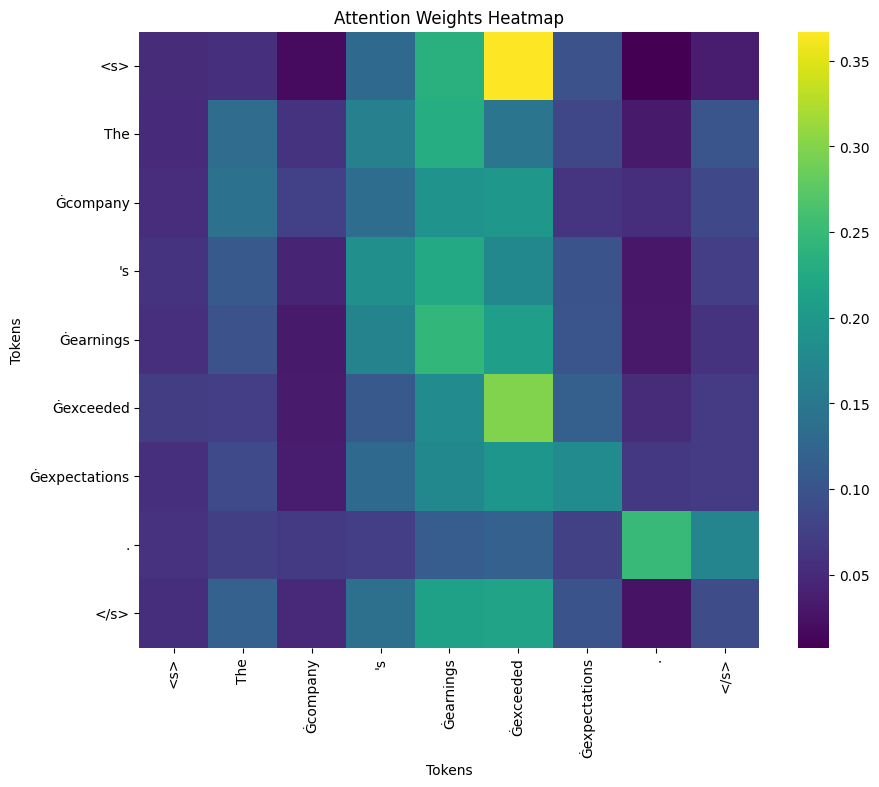

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the model and tokenizer
model_name = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Ensure model is in evaluation mode
model.eval()

def get_attention_weights(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    # Get the model's output (logits and attention weights)
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Get the attention scores from the last layer
    # outputs.attentions is a tuple of attention scores for all layers
    last_layer_attention = outputs.attentions[-1]  # Get the attention from the last layer

    return last_layer_attention, inputs['input_ids']

def visualize_attention(attention_weights, input_ids):
    # Convert input_ids to tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Average the attention weights across heads
    attention_weights = attention_weights.mean(dim=1).squeeze(0).numpy()  # Shape: [seq_len, seq_len]

    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title('Attention Weights Heatmap')
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.show()

# Example text
text = "The company's earnings exceeded expectations."

# Get attention weights
attention_weights, input_ids = get_attention_weights(text)

# Visualize attention weights
visualize_attention(attention_weights, input_ids)


Check the model accuracy after using attention transformer using the same synthetic dataset and compare

In [9]:
# Check accuracy again (
predictions_after_attention = pipe(list(texts))
predicted_labels_after_attention = [prediction['label'].lower() for prediction in predictions_after_attention]

# Calculate accuracy again
accuracy_after_attention = accuracy_score(actual_labels, predicted_labels_after_attention)

# Print the accuracy after attention visualization
print(f"Model Accuracy (after attention visualization): {accuracy_after_attention:.2f}")

Model Accuracy (after attention visualization): 0.80


Akurasi model tetap sama karena:

1. Model yang Sama

Digunakan model yang sama (DistilRoBERTa yang telah dilatih sebelumnya). Menambahkan visualisasi atau attention transformer tidak mengubah parameter model atau cara model melakukan inferensi.

2. Evaluasi yang Sama

Ketika dillakukan evaluasi pada dataset yang sama (synthetic dataset), hasil akurasi yang diperoleh akan konsisten. Model tidak belajar atau mengubah dirinya sendiri berdasarkan visualisasi atau cara lain dalam evaluasi tersebut.